# Lab 2
    -Robbie Keehan
    -Spencer Cheng
    -Max Goldstein

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import keras
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


Chose the valadation set of coco because it is smaller.

## Make VGG use unpooling 

This is taken directly from the example.

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import tensorflow.keras.backend as K
import h5py
import numpy as np
import tensorflow as tf

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    # f = h5py.File(WEIGHTS_PATH)
    # layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        # b_name = layer.name.encode()
        # if b_name in layer_names:
        #     g = f[b_name]
        #     weights = [g[name] for name in g.attrs['weight_names']]
        #     layer.set_weights(weights)
        layer.trainable = False

    # f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = tf.keras.applications.vgg19.VGG19()
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

Using TensorFlow backend.


# Professor Larson's Decoder


In [3]:
from keras.layers import Input, Conv2D, UpSampling2D

def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

## Training


In [4]:
import multiprocessing.pool
from functools import partial
import os

def _count_valid_files_in_directory(directory, white_list_formats, follow_links):
    """Count files with extension in `white_list_formats` contained in a directory.

    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.

    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

    samples = 0
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
                samples += 1
    return samples

def count_num_samples(directory):
    """
    From Keras DirectoryIterator
    """
    classes = []
    for subdir in sorted(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, subdir)):
            classes.append(subdir)

    white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'}
    pool = multiprocessing.pool.ThreadPool()
    function_partial = partial(_count_valid_files_in_directory,
                               white_list_formats=white_list_formats,
                               follow_links=False)
    num_samples = sum(pool.map(function_partial,
                               (os.path.join(directory, subdir)
                                for subdir in classes)))
    pool.close()
    pool.join()
    return num_samples

In [5]:
import sys
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
import numpy as np
from PIL import Image
import PIL
import imageio
import glob
import cv2

ModuleNotFoundError: No module named 'cv2'

In [0]:
import scipy
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

# Reconstruct Images from Decoder

In [6]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

In [7]:
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K

LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)

    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)

Lossy conversion from float32 to uint8. Range [0.0, 281.3880310058594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.1939682960510254, 188.09573364257812]. Convert image to uint8 prior to saving to suppress this warning.


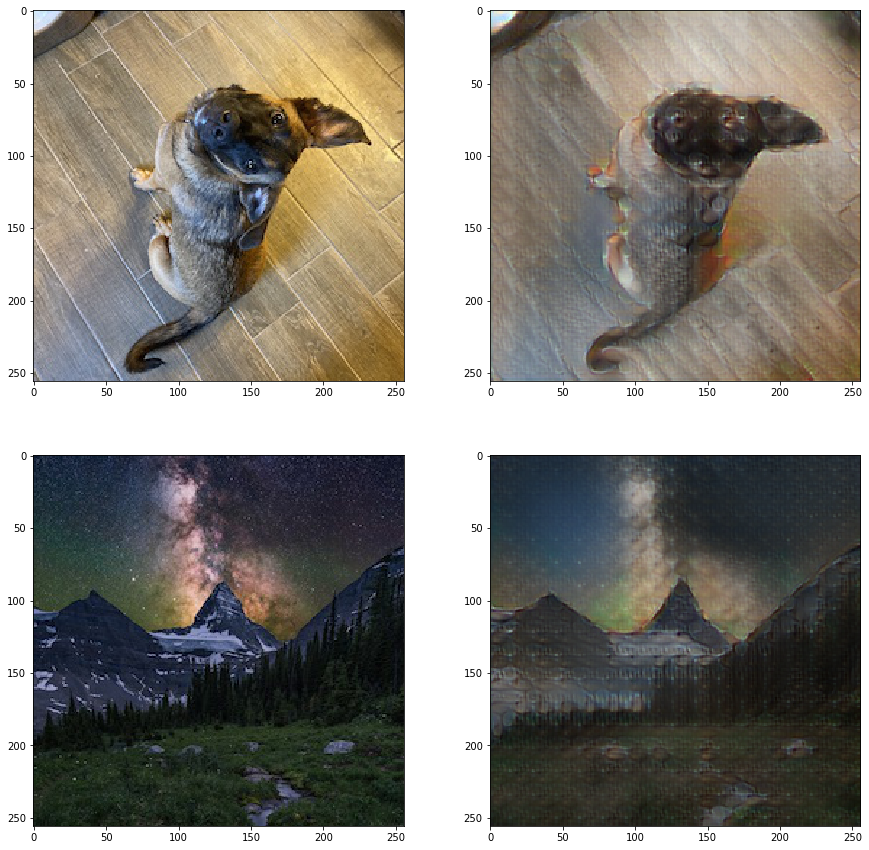

In [24]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))

#first example using decoder 5
DECODER_PATH = './decoder_5-6ep.h5'
INPUT_IMG_PATH = './Luna.jpg'
OUTPUT_IMG_PATH = './decoded-luna-1.jpg'
encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH)
input_img = load_img(INPUT_IMG_PATH)
input_img = img_to_array(input_img)
fig.add_subplot(2, 2, 1)
plt.imshow(np.clip(input_img / 255, 0, 1))
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
fig.add_subplot(2, 2, 2)
plt.imshow(np.clip(output_img / 255, 0, 1))
imageio.imwrite(OUTPUT_IMG_PATH, output_img)

#second example using decoder 5
INPUT_IMG_PATH = './MilkyWay.jpg'
OUTPUT_IMG_PATH = './decoded-mw-1.jpg'
# encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH)
input_img = load_img(INPUT_IMG_PATH)
input_img = img_to_array(input_img)
fig.add_subplot(2, 2, 3)
plt.imshow(np.clip(input_img / 255, 0, 1))
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
fig.add_subplot(2, 2, 4)
plt.imshow(np.clip(output_img / 255, 0, 1))
imageio.imwrite(OUTPUT_IMG_PATH, output_img)
plt.show()



The decoder above(decoder_5-6ep) works fairly well. There contect of the image is still visible, however there are some swirl-type artifacts.

Lossy conversion from float32 to uint8. Range [0.0, 20.27600860595703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.06748536229133606, 13.22234058380127]. Convert image to uint8 prior to saving to suppress this warning.


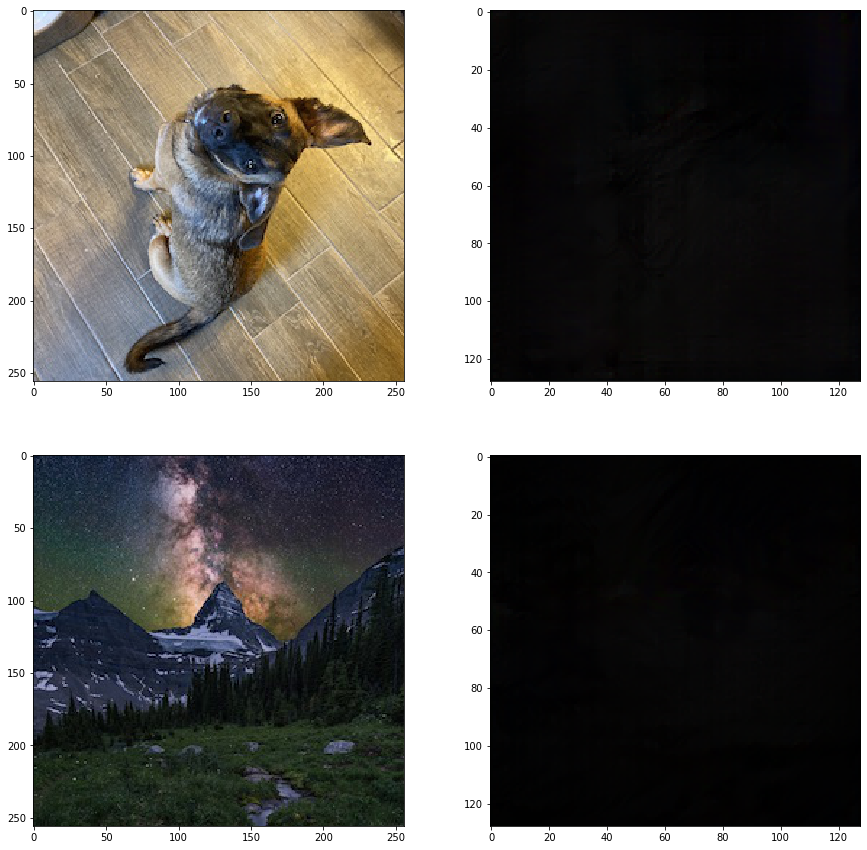

In [30]:
fig = plt.figure(figsize=(15, 15))
#first example using decoder 4
DECODER_PATH = './decoder_4-ep3.h5'
INPUT_IMG_PATH = './Luna.jpg'
OUTPUT_IMG_PATH = './decoded-luna-1.jpg'
encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH)
input_img = load_img(INPUT_IMG_PATH)
input_img = img_to_array(input_img)
fig.add_subplot(2, 2, 1)
plt.imshow(np.clip(input_img / 255, 0, 1))
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
fig.add_subplot(2, 2, 2)
plt.imshow(np.clip(output_img / 255, 0, 1))
imageio.imwrite(OUTPUT_IMG_PATH, output_img)

#second example using decoder 4
INPUT_IMG_PATH = './MilkyWay.jpg'
OUTPUT_IMG_PATH = './decoded-mw-1.jpg'
# encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH)
input_img = load_img(INPUT_IMG_PATH)
input_img = img_to_array(input_img)
fig.add_subplot(2, 2, 3)
plt.imshow(np.clip(input_img / 255, 0, 1))
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
fig.add_subplot(2, 2, 4)
plt.imshow(np.clip(output_img / 255, 0, 1))
imageio.imwrite(OUTPUT_IMG_PATH, output_img)
plt.show()

The above decoder(decoder_4-ep3) did not work at all, there is no noticable content from the original image.

In [31]:
TRAIN_PATH = './images/'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 8
epochs = 0

def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        test_img = load_img(test_img_path)
        test_img = img_to_array(test_img)
        test_target = resize_img(test_img, (256, 256, 3))
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model
        self.preview_dir_path = preview_dir_path
        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            imageio.imwrite(out_path, output_img)

        self.iteration += 1


gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)

num_samples = count_num_samples(TRAIN_PATH)
steps_per_epoch = num_samples // BATCH_SIZE

target_layer = int(4)

encoder_decoder = EncoderDecoder(target_layer=target_layer,decoder_path='./decoder_4-ep3.h5')

encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
        epochs=epochs)
encoder_decoder.export_decoder()

FileNotFoundError: [Errno 2] No such file or directory: './images/'

# Apply Whitening & Color Transform 

In [0]:
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np

content_url = './download.jpg'
style_url='./starry.jpeg'
OUTPUT_IMG_PATH = './style-transfer-1.jpg'


def get_vgg_features(vgg, inputs, target_layer):
    output_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1'
    ]

    outputs = [layer.output for layer in vgg.layers
               if layer.name == output_layers[target_layer-1]]
    f = K.function([vgg.input] + [K.learning_phase()], outputs)
    return f([inputs, 1])


def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py

       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       thttps://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)



img_c = image.load_img(content_url)
img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape
img_c = np.expand_dims(img_c, axis=0)

img_s = image.load_img(style_url)
img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape
img_s = np.expand_dims(img_s, axis=0)

assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))

input_shape = img_c_shape

print('Loading decoders...')
decoders = {}
decoders[5] = load_model('./decoder_5-6ep.h5')
decoders[4] = load_model('./decoder_4-ep3.h5')
print('Loading VGG...')
vgg = VGG19(input_shape=input_shape, target_layer=5)

import matplotlib.pyplot as plt

plt.imshow(np.clip(img_c[0] / 255, 0, 1))
plt.show()

plt.imshow(np.clip(img_s[0]/ 255, 0, 1))
plt.show()

print('Styling...')
for i in [5,4,5,4]:
    feats_c = get_vgg_features(vgg, img_c, i)
    feats_s = get_vgg_features(vgg, img_s, i)
    feats_cs = wct(feats_c, feats_s)
    img_c = decoders[i].predict(feats_cs)
    plt.imshow(np.clip(img_c[0] / 255, 0, 1))
    plt.show()

print('Saving output...')
output_img = img_c[0]

imageio.imwrite(OUTPUT_IMG_PATH, output_img)

## Add smoothing



In [0]:
from scipy.ndimage.filters import convolve
def getSigmas(img_con,k):
  conv_img = convolve(img_con, k, mode='constant', cval=0.0)
  return (img_con - conv_img) **2
k = np.array([[1/9,1/9,1/9],
              [1/9,1/9,1/9],
              [1/9,1/9,1/9]])

In [0]:
from scipy.sparse import coo_matrix
import math
stylized_url = './style-transfer-1.jpg'
content_url = './download.jpg'
img_stylized = image.load_img(stylized_url)
img_stylized = image.img_to_array(img_stylized)
img_stylized_shape = img_stylized.shape

# getting sigmas
img_con = image.load_img(content_url)
img_con = image.img_to_array(img_con)
img_con_shape = img_con.shape
img_avg = []
#gray scale
for i in range(256):
  img_avg.append([])
  for j in range(256):
    avg = (img_con[i][j][0] + img_con[i][j][1] + img_con[i][j][2]) / 3
    img_avg[i].append(avg)
img_con = np.array(img_avg)
sigmas = getSigmas(img_con,k)
#zero breaks things cause dividing by zero
for row,val in enumerate(sigmas):
  for col,val2 in enumerate(val):
    if(val2 == 0):
      sigmas[row][col] = 0.0001
gg = coo_matrix(((256*256), (256*256)), dtype=np.float32)
gg = gg.tocsr()
print(gg)
pixel_val = 0
#building out Wij
for row,val in enumerate(img_con):
  for col,val2 in enumerate(val):
    #edge case for the same row and col values so it is just zero
    if(row == col):
      gg[pixel_val,pixel_val] = 0
    #pixel to the right
    if(col < 255):
      gg[pixel_val,pixel_val+1] = math.exp(-((img_con[row][col] - img_con[row][col+1])**2)/sigmas[row][col])
    #pixel to the left
    if(col > 0):
      gg[pixel_val,pixel_val-1] =  math.exp(-((img_con[row][col] - img_con[row][col-1])**2)/sigmas[row][col])
    #pixel to the upper right
    if(col < 255 and row > 0):
      gg[pixel_val,pixel_val-255] =  math.exp(-((img_con[row][col] - img_con[row-1][col+1])**2)/sigmas[row][col])
    #pixel above
    if(row>0):
      gg[pixel_val,pixel_val-256] =  math.exp(-((img_con[row][col] - img_con[row-1][col])**2)/sigmas[row][col])
    #pixel to upper left
    if(col > 0 and row >0):
      gg[pixel_val,pixel_val-257] =  math.exp(-((img_con[row][col] - img_con[row-1][col-1])**2)/sigmas[row][col])
    #pixel to lower right
    if(row < 255 and col < 255 ):
      gg[pixel_val,pixel_val+257] =  math.exp(-((img_con[row][col] - img_con[row+1][col+1])**2)/sigmas[row][col])
    #pixel below
    if(row < 255):
      gg[pixel_val,pixel_val+256] =  math.exp(-((img_con[row][col] - img_con[row+1][col])**2)/sigmas[row][col])
    #pixel to lower left
    if(row < 255 and col > 0):
      gg[pixel_val,pixel_val+255] =  math.exp(-((img_con[row][col] - img_con[row+1][col-1])**2)/sigmas[row][col])
    pixel_val +=1
  print(pixel_val)
# # calc D

# # calc W
# R = (1 - alpha) * (identity_matrix - alpha*D)

/tensorflow-2.1.0/python3.6/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
6144
6400
6656
6912
7168
7424
7680
7936
8192
8448
8704
8960
9216
9472
9728
9984
10240
10496
10752
11008
11264
11520
11776
12032
12288
12544
12800
13056
13312
13568
13824
14080
14336
14592
14848
15104
15360
15616
15872
16128
16384
16640
16896
17152
17408
17664
17920
18176
18432
18688
18944
19200
19456
19712
19968
20224
20480
20736
20992
21248
21504
21760
22016
22272
22528
22784
23040
23296
23552
23808
24064
24320
24576
24832
25088
25344
25600
25856
26112
26368
26624
26880
27136
27392
27648
27904
28160
28416
28672
28928
29184
29440
29696
29952
30208
30464
30720
30976
31232
31488
31744
32000
32256
32512
32768
33024
33280
33536
33792
34048
34304
34560
34816
35072
35328
35584
35840
36096
36352
36608
36864
37120
37376
37632
37888
38144
38400
38656
38912
39168
39424
39680
39936
40192
40448
40704
40960
41216
41472
41728
41984
42240
42496
42752
43008
43264
43520
43776
44032
44288
4454

In [0]:
d = coo_matrix(((256*256), (256*256)), dtype=np.float32)
d = d.tocsr()
for row,val in enumerate(gg):
  d_val = 0
  #pixel to the right
  if(row % 256  != 255):
    d_val += gg[row,row+1] 
  #pixel to the left
  if(row % 256  != 0):
    d_val += gg[row,row-1] 
  #pixel to the upper right
  if((row % 256  != 255) and row > 255):
    d_val += gg[row,row-255]
  #pixel above
  if(row>255):
    d_val += gg[row,row-256]
  #pixel to upper left
  if((row % 256  != 0) and row >255):
    d_val += gg[row,row-257] 
  #pixel to lower right
  if(row < 65280 and (row % 256  != 255)):
    d_val += gg[row,row+257]
  #pixel below
  if(row < 65280):
    d_val += gg[row,row+256] 
  #pixel to lower left
  if(row < 65280 and (row % 256  != 0)):
    d_val += gg[row,row+255]
  if(d_val == 0):
    d_val = 0.001
  d[row,row] = (1/d_val)**(1/2)

/tensorflow-2.1.0/python3.6/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [0]:
y = coo_matrix(((256*256), (256*256)), dtype=np.float32)
y = y.tocsr()
#building out Y
pixel_val = 0
for row,val in enumerate(img_con):
  for col,val2 in enumerate(val):
    y[pixel_val,pixel_val] = val2
    pixel_val+=1

/tensorflow-2.1.0/python3.6/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [0]:
i = coo_matrix(((256*256), (256*256)), dtype=np.float32)
i = i.tocsr()
#building out i
pixel_val = 0
for row,val in enumerate(img_con):
  for col,val2 in enumerate(val):
    i[pixel_val,pixel_val] = 1
    pixel_val+=1

/tensorflow-2.1.0/python3.6/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [0]:
# warning said these would be fast
gg = gg.tocsc()
d = d.tocsc()
i = i.tocsc()
y = y.tocsc()

In [0]:
from scipy.sparse.linalg import inv
alpha = 0.5
part1 =  (d @ gg @ d)
print('part1')
part2 = i - (alpha * part1)
print('part2')
part3 = inv(part2) 
print('part3')
part4 = (1.0-alpha) *  part3
print('part4')
R = part4 @ y
print(':)')
# R = (1.0-alpha) * (i - alpha * d @ gg @ d ) ** (-1.0) @ y

part1
part2


In [0]:
print(R.shape)
print(R[0,0])

In [0]:
result = np.zeros((1,256, 256,3))
#building out Y
pixel_val = 0
for row,val in enumerate(img_con):
  for col,val2 in enumerate(val):
    result[0][row][col] = [R[pixel_val,pixel_val],R[pixel_val,pixel_val],R[pixel_val,pixel_val]]
    pixel_val+=1

In [0]:
print(img_c.shape)
print(result.shape)
plt.imshow(np.clip(result[0] / 255, 0, 1))
plt.show()

In [0]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [33]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2020-03-06 21:54:25--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.10.155
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.10.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip           2%[                    ] 167.95M   877KB/s    eta 1h 47m ^C


In [0]:
!unzip val2014.zip

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = K.tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    K.tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [0]:
from keras import backend as K
from keras.layers import Layer
from keras.utils import conv_utils
from keras import backend as K
from keras.layers import Layer, Lambda, Conv2D
# from tensorflow.python.ops import nn_ops
from keras import initializers, regularizers, constraints, activations
from keras.utils import conv_utils
class MaxPoolingWithArgmax2D(Layer):
    '''MaxPooling for unpooling with indices.
    
    # References
        [SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation](http://arxiv.org/abs/1511.00561)
    
    # related code:
        https://github.com/PavlosMelissinos/enet-keras
        https://github.com/ykamikawa/SegNet
    '''
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='same', **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.pool_size = conv_utils.normalize_tuple(pool_size, 2, 'pool_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)

    def call(self, inputs, **kwargs):
        ksize = [1, self.pool_size[0], self.pool_size[1], 1]
        strides = [1, self.strides[0], self.strides[1], 1]
        padding = self.padding.upper()
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, padding)
        argmax = tf.cast(argmax, K.floatx())
        return [output, argmax]
    
    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [dim // ratio[idx] if dim is not None else None for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

In [0]:
class MaxUnpooling2D(Layer):
    '''Inversion of MaxPooling with indices.
    
    # References
        [SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation](http://arxiv.org/abs/1511.00561)
    
    # related code:
        https://github.com/PavlosMelissinos/enet-keras
        https://github.com/ykamikawa/SegNet
    '''
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        
        mask = tf.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')
        #  calculation new shape
        if output_shape is None:
            output_shape = (input_shape[0], input_shape[1] * self.size[0], input_shape[2] * self.size[1], input_shape[3])
        
        # calculation indices for batch, height, width and feature maps
        one_like_mask = K.ones_like(mask, dtype='int32')
        batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'), shape=batch_shape)
        b = one_like_mask * batch_range
        y = mask // (output_shape[2] * output_shape[3])
        x = (mask // output_shape[3]) % output_shape[2]
        feature_range = tf.range(output_shape[3], dtype='int32')
        f = one_like_mask * feature_range
        
        # transpose indices & reshape update values to one dimension
        updates_size = tf.size(updates)
        indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
        values = K.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret
    
    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        output_shape = [mask_shape[0], mask_shape[1] * self.size[0], mask_shape[2] * self.size[1], mask_shape[3]]
        return tuple(output_shape)

In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
from keras.layers import Concatenate
import h5py
import numpy as np
import scipy

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])


def vgg_layers(inputs, target_layer):

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    #added this to make stirdes to the convolution layer
    #repeated it for each ending conolution in VGG
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x, arg_1 = MaxPoolingWithArgmax2D(pool_size=2,strides=(2,2),name='block1_pool')(x)
    print(x)
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x, arg_2 = MaxPoolingWithArgmax2D(pool_size=2,strides=(2,2),name='block2_pool')(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x, arg_3 = MaxPoolingWithArgmax2D(pool_size=2,strides=(2,2),name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x, arg_4 = MaxPoolingWithArgmax2D(pool_size=2,strides=(2,2),name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return Concatenate([x,arg_1,arg_2,arg_3,arg_4])


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    print(model.summary())
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

In [0]:
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = 
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        print('output shape',self.encoder.output_shape[0][1:])
        inputs = Input(shape=self.encoder.output_shape[0][1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)

    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)

In [0]:
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose

def decoder_layers(inputs,layer):
    print(inputs)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x
    print('xxxx',x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x